In [20]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import re
import emoji
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [21]:

stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

# 1. Load Dataset & Lexicons

In [ ]:
print("=== [1] Load Dataset & Lexicons ===")
df = pd.read_csv("datasets_raw/datasets_fomo_10000_nolabel.csv")
print(f"Jumlah data awal: {len(df)}")

# Load slang lexicon
slang_df = pd.read_csv("dict/colloquial-indonesian-lexicon.csv")
slang_dict = dict(zip(slang_df['slang'], slang_df['formal']))

# Load positive & negative lexicon
positive_lexicon = pd.read_csv("lexicon/positive.tsv", sep="\t", header=None, names=["word", "label"])
negative_lexicon = pd.read_csv("lexicon/negative.tsv", sep="\t", header=None, names=["word", "label"])
positive_words = set(positive_lexicon['word'].tolist())
negative_words = set(negative_lexicon['word'].tolist())



=== [1] Load Dataset & Lexicons ===
Jumlah data awal: 9546
Jumlah slang term: 4331
Lexicon Positif: 3610, Lexicon Negatif: 6608


# 2. Preprocessing Functions

In [22]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def normalize_slang(text, slang_dict):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return " ".join(normalized_words)

def remove_stopwords(text):
    return stopword_remover.remove(text)

def stem_text(text):
    return stemmer.stem(text)
# ---------------------------------------------------------

def lexicon_label(text):
    words = text.split()
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    if pos_count > neg_count:
        return "positive"
    elif neg_count > pos_count:
        return "negative"
    else:
        return "neutral"

# 3. Load IndoBERT Sentiment Model

In [23]:
print("\n=== [3] Load IndoBERT Sentiment Model ===")
pretrained = "mdhugol/indonesia-bert-sentiment-classification"
model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

def indobert_label_with_score(text):
    try:
        result = sentiment_pipeline(text[:512])[0]
        label = label_index[result['label']]
        score = result['score']
        return label, score
    except:
        return "neutral", 0.0


=== [3] Load IndoBERT Sentiment Model ===


Device set to use cuda:0


# 4. Apply Preprocessing

In [24]:
print("\n=== [4] Preprocessing & Labeling (Pipeline Lengkap) ===")
tqdm.pandas()

# 1. Cleaning & Normalisasi (Dasar untuk semua)
print("Tahap 1: Membersihkan dan menormalisasi teks...")
df['text_clean'] = df['full_text'].progress_apply(clean_text)
df['text_clean'] = df['text_clean'].progress_apply(lambda x: normalize_slang(x, slang_dict))

# 2. Stopword Removal & Stemming (LEXIOCON)
print("\nTahap 2: Membuat teks versi stemmed untuk analisis leksikon...")
df['text_lexicon'] = df['text_clean'].progress_apply(remove_stopwords)
df['text_lexicon'] = df['text_lexicon'].progress_apply(stem_text)

# 3. Prediksi dengan IndoBERT (menggunakan text_clean)
print("\nTahap 3: Melakukan prediksi sentimen dengan IndoBERT...")
df[['label_model', 'model_conf']] = df['text_clean'].progress_apply(
    lambda x: pd.Series(indobert_label_with_score(x))
)

# 4. Prediksi dengan Lexicon 
print("\nTahap 4: Melakukan prediksi sentimen dengan metode leksikon...")
df['label_lexicon'] = df['text_lexicon'].progress_apply(lexicon_label)

print("\nContoh hasil preprocessing dan labeling:")
print(df[['text_clean', 'text_lexicon', 'label_model', 'model_conf', 'label_lexicon']].head(10))


=== [4] Preprocessing & Labeling (Pipeline Lengkap) ===
Tahap 1: Membersihkan dan menormalisasi teks...


100%|██████████| 9546/9546 [00:00<00:00, 225180.12it/s]



Tahap 2: Membuat teks versi stemmed untuk analisis leksikon...


100%|██████████| 9546/9546 [20:14<00:00,  7.86it/s]  



Tahap 3: Melakukan prediksi sentimen dengan IndoBERT...


100%|██████████| 9546/9546 [02:09<00:00, 73.76it/s]



Tahap 4: Melakukan prediksi sentimen dengan metode leksikon...


100%|██████████| 9546/9546 [00:00<00:00, 222897.34it/s]


Contoh hasil preprocessing dan labeling:
                                          text_clean  \
0  suara jaehyun tuh tipe suara yang pengin kamu ...   
1  lucu banget melihat kalian pada takut tidurrr ...   
2  catchingdoie yaampun kak aku auto lihat jam ta...   
3      mau bobo tapi takut ketinggalan sesuatu nanti   
4                                  takut ketinggalan   
5  okey siap beberapa hari kedepan enggak boleh t...   
6  lagian sekelas wamen marah dan nyuruh nya kok ...   
7  ada orang ngerjain skripsi selalu di cafe demi...   
8  upload foto survei ada beberapa yang reply itu...   
9  jaeminshii sumpah kagak tau ini juga dari moot...   

                                        text_lexicon label_model  model_conf  \
0  suara jaehyun tuh tipe suara pengin kamu denga...    positive    0.923542   
1  lucu banget lihat kalian takut tidurrr alias t...    positive    0.566046   
2  catchingdoie yaampun kak aku auto lihat jam ta...     neutral    0.749998   
3                    

# 5. EDA (Distribusi Confidence & Label)


=== [5] EDA (Distribusi Confidence & Label) ===


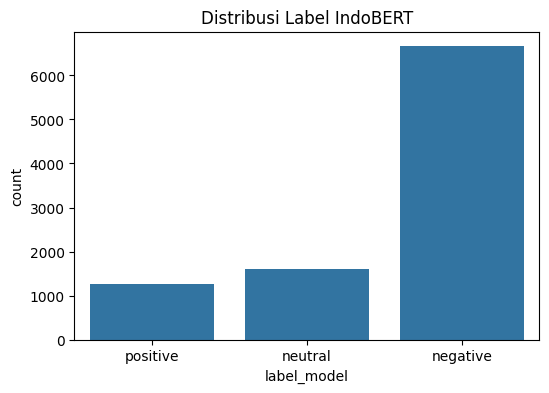

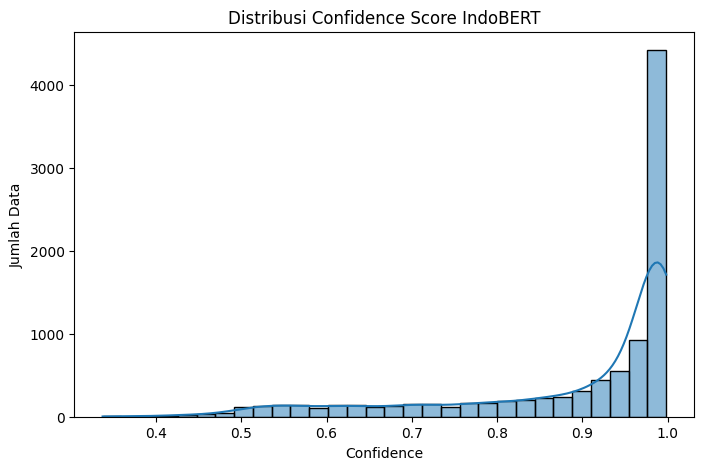

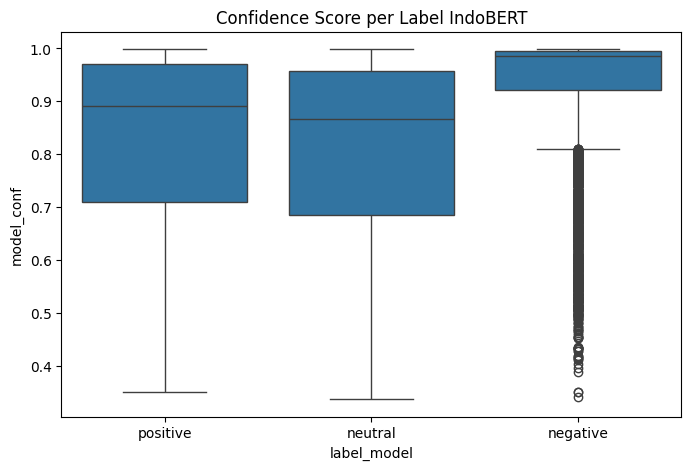

In [25]:
print("\n=== [5] EDA (Distribusi Confidence & Label) ===")
plt.figure(figsize=(6,4))
sns.countplot(x='label_model', data=df)
plt.title("Distribusi Label IndoBERT")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df['model_conf'], bins=30, kde=True)
plt.title("Distribusi Confidence Score IndoBERT")
plt.xlabel("Confidence")
plt.ylabel("Jumlah Data")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='label_model', y='model_conf', data=df)
plt.title("Confidence Score per Label IndoBERT")
plt.show()

# 6. Hybrid Labeling with Threshold

In [26]:
print("\n=== [6] Hybrid Labeling with Threshold ===")
HIGH_CONF = 0.61

def hybrid_labeling(row):
    model_label = row['label_model']
    model_score = row['model_conf']
    lex_label = row['label_lexicon']

    if model_score >= HIGH_CONF:
        return model_label, "valid"
    if model_score < HIGH_CONF:
        if lex_label in ["positive", "negative"] and model_label == "neutral":
            return lex_label, "valid"
        elif model_label in ["positive", "negative"] and lex_label == "neutral":
            return model_label, "valid"
        elif lex_label == model_label:
            return model_label, "valid"
        else:
            return None, "ambiguous"

df[['final_label', 'status']] = df.progress_apply(hybrid_labeling, axis=1, result_type="expand")
print("Proses pelabelan hibrida selesai.")


=== [6] Hybrid Labeling with Threshold ===


100%|██████████| 9546/9546 [00:00<00:00, 37451.21it/s]

Proses pelabelan hibrida selesai.


# 7. Analisis Distribusi Final Label

In [27]:
print("\nDistribusi final label:")
print(df['final_label'].value_counts(dropna=False))

df_valid = df[df['status'] == "valid"]
df_ambiguous = df[df['status'] == "ambiguous"]

print(f"\nJumlah valid: {len(df_valid)} | Jumlah ambiguous: {len(df_ambiguous)}")

# Simpan hasil
df_valid.to_csv("datasets/train_ready_3class_10000_2.csv", index=False)
df_ambiguous.to_csv("datasets/ambiguous_3class_10000_2.csv", index=False)

print("\n✅ Proses selesai! File disimpan.")


Distribusi final label:
final_label
negative    6706
neutral     1418
positive    1253
None         169
Name: count, dtype: int64

Jumlah valid: 9377 | Jumlah ambiguous: 169

✅ Proses selesai! File disimpan.



Jumlah Data Valid per Threshold:
   Threshold  Jumlah_Data
0        0.6         8801
1        0.7         8200
2        0.8         7499
3        0.9         6489


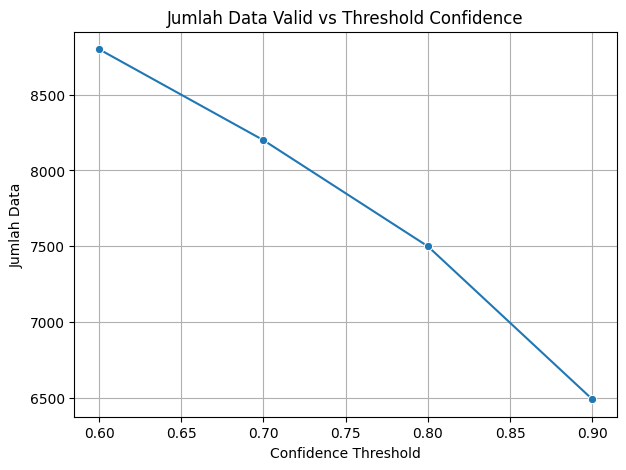

In [28]:
thresholds = [0.6, 0.7, 0.8, 0.9]
results = []
for t in thresholds:
    valid_count = len(df[df['model_conf'] >= t])
    results.append((t, valid_count))

threshold_df = pd.DataFrame(results, columns=['Threshold', 'Jumlah_Data'])
print("\nJumlah Data Valid per Threshold:")
print(threshold_df)

# Visualisasi threshold vs jumlah data
plt.figure(figsize=(7,5))
sns.lineplot(x='Threshold', y='Jumlah_Data', data=threshold_df, marker='o')
plt.title("Jumlah Data Valid vs Threshold Confidence")
plt.xlabel("Confidence Threshold")
plt.ylabel("Jumlah Data")
plt.grid(True)
plt.show()